In [ ]:
path = '/Users/fanyang/Documents/tensorflow_file/facedetection/traindata'
filenames = os.listdir(path)
for filename in filenames:
    os.rename(os.path.join(path, filename), os.path.join(path, filename.replace(' ', '-')))

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
train_data = '/Users/fanyang/Documents/tensorflow_file/facedetection/traindata'
test_data = '/Users/fanyang/Documents/tensorflow_file/facedetection/testdata'



In [3]:
def listDIRonly(path):
    return [filename for filename in os.listdir(path) if os.path.isdir(os.path.join(path,filename))]
# 'os.listdir' 以列表形式返回指定目录下的 files and folder
# 'os.path.isdir' Return True if path is an existing directory.




# only for jpg. here
#def listJPGimage(path):
#    return [filename for filename in os.listdir(path) if os.path.isdir(os.path.join(path, filename))]


def listJPGimage(path):
    return [filename for filename in os.listdir(path) if filename.endswith(".jpg")]
#

In [4]:
# print out class names, because this is multiple classes 
class_list = np.sort(np.unique(listDIRonly(train_data)))
print(class_list)

['JasonMomoa' 'JohnnyDepp' 'PatrickWilson' 'RyanReynolds' 'WillemDafoe']


In [5]:
import cv2 as cv

def generateData(path, class_list):
    data = [] # the order of the data is the same as the class list
    for label in class_list:
        target_dir = os.path.join(path, label)
        images = listJPGimage(target_dir)
        data.append([cv.imread(os.path.join(target_dir, image)) for image in images])
    return data

In [6]:
data_train = generateData(train_data, class_list)

In [7]:
data_test = generateData(test_data, class_list)

In [8]:
len(data_train[0])

15

In [9]:
print(len(data_train[0]))
print(len(data_test[0]))
print(data_train[0][0].shape)

15
5
(225, 225, 3)


In [ ]:
for i in range(5):
    print(len(data_train[i]))
    print(len(data_test[i]))

In [ ]:
for m in range(5):
    for n in range(15):
        print(data_train[m][n].shape)

In [ ]:
for m in range(5):
    for n in range(5):
        print(data_test[m][n].shape)

In [ ]:
# pre-processing data, locate the face
# allow image to rotate from -60 to 60

In [10]:
# rotate face between -60 to 60 degree, record the max weight at each angle
# find the best face


def rotate_image_without_crop(image, angle):
    
    (h, w) = image.shape[:2]
    (cX, cY) = (w / 2., h / 2.)
 
    M = cv.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
 
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
 
    return cv.warpAffine(image, M, (nW, nH))

def crop_image(img, faceR):
    (x, y, w, h) = faceR
    return img[y:y+h, x:x+w].copy()

def detect_face(image):
#     cascadePath = os.path.join(cv.data.haarcascades, "haarcascade_frontalface_default.xml")

    cascadePath = os.path.join(cv.data.haarcascades, "haarcascade_frontalface_alt.xml")
    result = None
    imageGray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    cascade = cv.CascadeClassifier(cascadePath)
    
    angle_range = np.arange(-60, 60, 5)
    
    best_face = None
    best_angle = None
    max_weight = 0
    for angle in angle_range:
        imageGray_rotated = rotate_image_without_crop(imageGray, angle)
        # there may be multiple faces in a pic
        # larger minNeighbors means lower false postive
        faceRects, rejectLevels, levelWeights = cascade.detectMultiScale3(imageGray_rotated, scaleFactor=1.05, minNeighbors=3, minSize=(5,5), outputRejectLevels=True)
    
        if len(faceRects) <= 0:
            continue
        else:
            # for all the faces detected in a pic, find the largest shape one. It is our assumption
            # when doing prediciton, it is of course not a problem to do multiple face detection
            # but in training, it is hard to believe there are two faces of the same person.
            face, weight = max([(faceR, weight) for faceR, weight in zip(faceRects, levelWeights)], key = lambda x: x[0][2]*x[0][3]) 
#             print weight, angle
            if (weight > max_weight):
                max_weight = weight
                best_face = face
                best_angle = angle
    
    if(best_face is None):
        return None
    else:
        rotated_img = rotate_image_without_crop(image, best_angle)
        return crop_image(rotated_img, best_face)

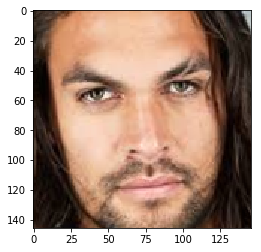

In [11]:
# see an example

image = cv.imread('/Users/fanyang/Documents/tensorflow_file/facedetection/traindata/JasonMomoa/images (8).jpg')
detected_face = detect_face(image)
plt.imshow(detected_face[:,:,::-1])
plt.show()

In [ ]:
image.shape

### 批量操作所有图片

In [ ]:
# now we define our model system

# for the training and validation data, call detect_face and save the result for training
# for prediction, use the same face detection function to find the face, then feed to the model

In [12]:
# work on training and validation data

def generateAligneddata(data_list):
    result = []
    for images in data_list:
        temp = []
        for image in images:
            aligned_image = detect_face(image)
            #assert (aligned_image) is not None
            temp.append(aligned_image)
        result.append(temp)
    return result

In [13]:
data_train_aligned = generateAligneddata(data_train)
data_test_aligned = generateAligneddata(data_test)

In [14]:
def img_resize_prepare(image_list, class_list, size):
    result = []
    for index, images in enumerate(image_list):
        for image in images:
            result.append((cv.resize(image,size),class_list[index]))
    return result

In [15]:
data_test_aligned_tosave244 = img_resize_prepare(data_test_aligned, class_list, (224, 224))

In [16]:
data_train_aligned_tosave244 = img_resize_prepare(data_train_aligned, class_list, (224, 224))

In [31]:
import pickle
pickle.dump(data_train_aligned_tosave244, open('image_actordata_train224.pk1', 'wb'))
pickle.dump(data_test_aligned_tosave244, open('image_actordata_test224.pk1', 'wb'))
pickle.dump(class_list, open('class_actorlist.pk1', 'wb'))

In [20]:
print(len(data_test_aligned[0]))

5


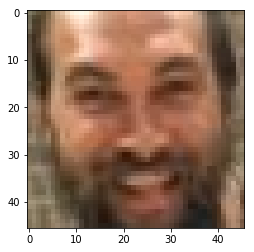

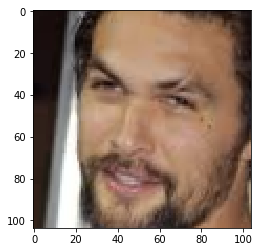

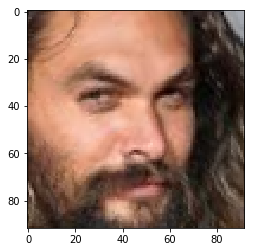

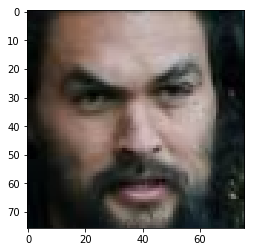

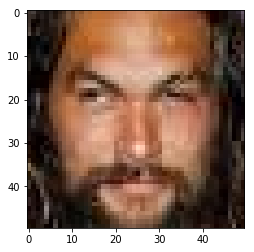

In [21]:
for image in data_test_aligned[0]:
    plt.imshow(image[:,:,::-1])
    plt.show()

### method 1: use structure of other neural network
#### if want to use mnist model, need to convert image into 28*28 gray pictures

In [22]:
def to_gray_and_resize(image_list, size, class_list):
    # change to gray image
    # resize
    result = []
    for index, images in enumerate(image_list):
        for image in images:
            result.append((cv.resize(cv.cvtColor(image, cv.COLOR_BGR2GRAY), size), class_list[index]))
    return result

In [23]:
# variable using long names on purpose, help with understanding the status
data_train_aligned_gray_resized_with_label = to_gray_and_resize(data_train_aligned, (28,28), class_list)
data_test_aligned_gray_resized_with_label = to_gray_and_resize(data_test_aligned, (28,28), class_list)

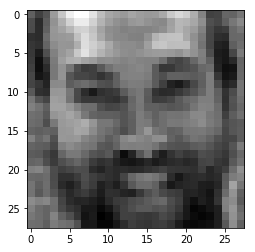

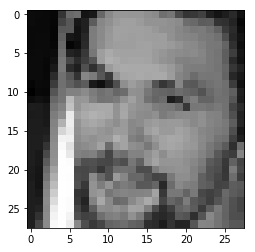

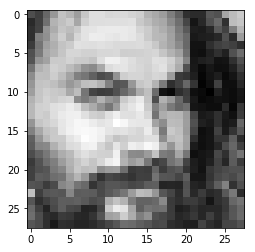

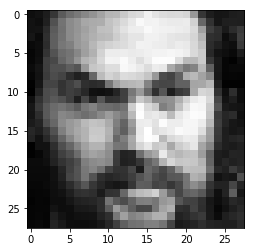

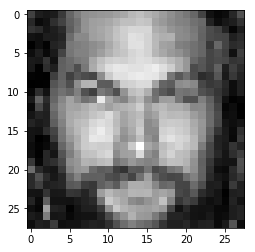

In [24]:
for (image, label) in data_test_aligned_gray_resized_with_label[:5]:
    plt.imshow(image, cmap='gray')
    plt.show()

In [25]:
# again, logistic regression
# neural network usually requires normalized input
X_train = np.array([x[0].reshape(784,)/255. for x in data_train_aligned_gray_resized_with_label])
X_test = np.array([x[0].reshape(784,)/255. for x in data_test_aligned_gray_resized_with_label])

Y_train = np.array([x[1] for x in data_train_aligned_gray_resized_with_label])
Y_test = np.array([x[1] for x in data_test_aligned_gray_resized_with_label])

print (X_train.shape)
print (Y_train.shape)

(75, 784)
(75,)


In [26]:
from collections import Counter
print (Counter(Y_train))
print (Counter(Y_test))

Counter({'JasonMomoa': 15, 'JohnnyDepp': 15, 'PatrickWilson': 15, 'RyanReynolds': 15, 'WillemDafoe': 15})
Counter({'JasonMomoa': 5, 'JohnnyDepp': 5, 'PatrickWilson': 5, 'RyanReynolds': 5, 'WillemDafoe': 5})


In [27]:
from sklearn.linear_model import LogisticRegression as LR

model = LR()
model.fit(X_train, Y_train)
print ("scores from lr: ",  model.score(X_train, Y_train), model.score(X_test, Y_test))

scores from lr:  1.0 0.48


### remember the image processing following: align ---> gray ---> resized

### np.random.shuffle : make your data randomly enter into training example

In [28]:
# now let's generate the data that can be fed into the network we used for mnist

train_data_final = data_train_aligned_gray_resized_with_label[:]

np.random.shuffle(train_data_final)

In [29]:
import tensorflow as tf
import numpy as np
import sys

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# with some minor changes
def create_network_2(input_dimension=784, output_dimension=5):
    # tf Graph input
    reset_graph()
    X = tf.placeholder(tf.float32, [None, 28, 28])
    X_reshaped = tf.reshape(X, shape=[-1, 28, 28, 1]) # what does the -1 mean? Why we need this? X is NOT only one image
    Y = tf.placeholder(tf.float32, [None, output_dimension])
    
    prob = tf.placeholder_with_default(1.0, shape=())
    
    # conv layer
    W_conv_1 = tf.Variable(tf.random_normal([3, 3, 1, 32])) # 3x3 filter, 32 filters, what does this 1 mean?
    prod_conv_1 = tf.nn.conv2d(X_reshaped, W_conv_1, strides=[1,1,1,1], padding='SAME', data_format='NHWC') # data format is default
    b_conv_1 = tf.Variable(tf.random_normal([32]))
    out_conv_1 = tf.nn.relu(tf.nn.bias_add(prod_conv_1, b_conv_1)) 
    
    # max pooling (guess which year is it invented? 30 years ago...)
    # "in all cases, pooling helps to make the representation approximately invariant to small translations"
    out_pool = tf.nn.max_pool(out_conv_1, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='SAME')
    
    # what is the dimension of the output of this layer?
    # dynamically determine the shape
    out_pool_dim = tf.reshape(out_pool[0],[-1]).get_shape().as_list()[0]
    
    # dense layer
    in_dense = tf.reshape(out_pool, [-1,out_pool_dim])
    
    # apply dropout, one way of regularization
    in_dense_dropout = tf.nn.dropout(in_dense, prob, seed=42)
    
    W_dense = tf.Variable(tf.random_normal([out_pool_dim, output_dimension]))
    b_dense = tf.Variable(tf.random_normal([output_dimension]))
                          
    out_dense = tf.add(tf.matmul(in_dense_dropout, W_dense), b_dense)
    prediction = tf.nn.softmax(out_dense)

    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=out_dense, labels=Y))
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0005)
    train_op = optimizer.minimize(loss_op)
    
    # Evaluate model
    correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # Initialize the variables (i.e. assign their default value)
    init = tf.global_variables_initializer()
    
    # saver = tf.train.Saver()
    return X, Y, prob, loss_op, train_op, accuracy, prediction, init

from sklearn.preprocessing import label_binarize

def runNetwork(train_data, test_data, class_list, X, Y, prob, loss_op, train_op, accuracy, prediction, init, num_steps = 2400, batch_size=40, display_step=200):
    # Start training
    with tf.Session() as sess:

        # Run the initializer
        sess.run(init)
        
        X_train = np.array([x[0] for x in train_data])
        Y_train = label_binarize(np.array([x[1] for x in train_data]), class_list)
        N = len(X_train)
        
                
        X_test = np.array([x[0] for x in test_data])
        Y_test = label_binarize(np.array([x[1] for x in test_data]), class_list)
        


        for step in range(1, num_steps+1):
            x = X_train[batch_size*(step-1)%N : batch_size*(step-1)%N+batch_size] # array of matrices (28 by 28)
            y_labels = Y_train[batch_size*(step-1)%N : batch_size*(step-1)%N+batch_size] # array of y_label
            # but for now y_label is not one-hot encoder
            y = label_binarize(y_labels, class_list)
            
            # Run optimization op (backprop)
            sess.run(train_op, feed_dict={X: x, Y: y, prob: 0.5})
            if step % display_step == 0 or step == 1:
                # Calculate training loss and accuracy
                loss, acc = sess.run([loss_op, accuracy], feed_dict={X: X_train, Y: Y_train})
                print ("Step " + str(step) + ", Training Loss= " + \
                      "{:.4f}".format(loss) + ", Training Accuracy= " + \
                      "{:.3f}".format(acc))
                loss, acc = sess.run([loss_op, accuracy], feed_dict={X: X_test, Y: Y_test})
                print ("Step " + str(step) + ", Test Loss= " + \
                      "{:.4f}".format(loss) + ", Test Accuracy= " + \
                      "{:.3f}".format(acc))
                sys.stdout.flush()
        

        print ("Optimization Finished! Step: ", step)

        # Calculate accuracy for test set
        print ("Testing Accuracy:", \
            sess.run(accuracy, feed_dict={X: X_test,
                                          Y: Y_test}))
            
        writer = tf.summary.FileWriter("./temp", graph=tf.get_default_graph())
            
        return sess.run(prediction, feed_dict={X: X_test, Y: Y_test})

reset_graph()                                
X, Y, prob, loss_op, train_op, accuracy, prediction, init = create_network_2()
predictions = runNetwork(train_data_final, data_test_aligned_gray_resized_with_label, class_list, X, Y, prob, loss_op, train_op, accuracy, prediction, init)                     
                        

/usr/local/Cellar/python/3.7.1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


Step 1, Training Loss= 45076.2031, Training Accuracy= 0.227
Step 1, Test Loss= 47363.2617, Test Accuracy= 0.120
Step 200, Training Loss= 15858.6162, Training Accuracy= 0.333
Step 200, Test Loss= 20928.1719, Test Accuracy= 0.080
Step 400, Training Loss= 7907.6201, Training Accuracy= 0.467
Step 400, Test Loss= 15161.6904, Test Accuracy= 0.240
Step 600, Training Loss= 3550.1467, Training Accuracy= 0.653
Step 600, Test Loss= 12259.8887, Test Accuracy= 0.360
Step 800, Training Loss= 2050.1021, Training Accuracy= 0.800
Step 800, Test Loss= 9619.1279, Test Accuracy= 0.440
Step 1000, Training Loss= 1386.9797, Training Accuracy= 0.840
Step 1000, Test Loss= 8210.9424, Test Accuracy= 0.520
Step 1200, Training Loss= 1093.3906, Training Accuracy= 0.867
Step 1200, Test Loss= 7368.8379, Test Accuracy= 0.520
Step 1400, Training Loss= 424.8953, Training Accuracy= 0.907
Step 1400, Test Loss= 6125.2251, Test Accuracy= 0.640
Step 1600, Training Loss= 284.4067, Training Accuracy= 0.947
Step 1600, Test Loss

predicted:  JohnnyDepp ; actual:  JasonMomoa


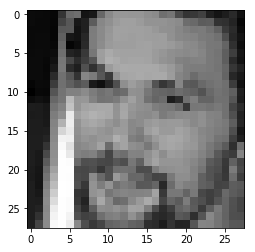

predicted:  WillemDafoe ; actual:  JohnnyDepp


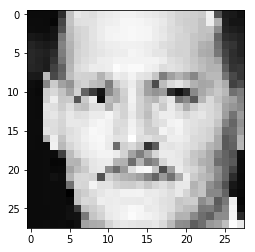

predicted:  WillemDafoe ; actual:  JohnnyDepp


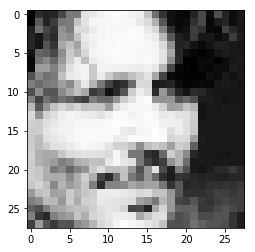

predicted:  JasonMomoa ; actual:  WillemDafoe


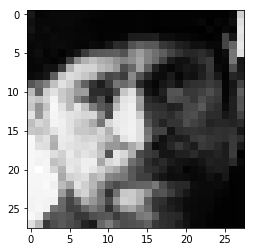

predicted:  RyanReynolds ; actual:  WillemDafoe


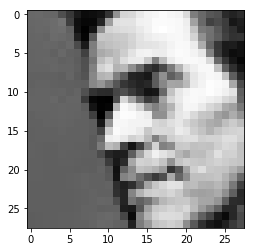

predicted:  RyanReynolds ; actual:  WillemDafoe


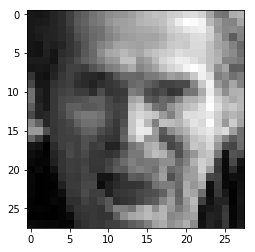

predicted:  RyanReynolds ; actual:  WillemDafoe


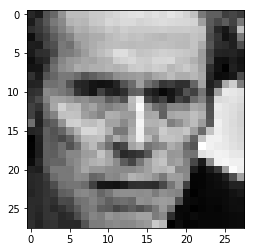

In [30]:
for (prediction, actual, x) in zip(predictions, Y_test, X_test):
    if class_list[np.argmax(prediction)] != actual:
        print ("predicted: ", class_list[np.argmax(prediction)], "; actual: ", actual)
        plt.imshow(x.reshape(28, 28), cmap='gray')
        plt.show()